In [1]:
import MetaTrader5 as mt5
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import talib as ta

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers.core import Dense, Flatten, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

pd.options.mode.chained_assignment = None

In [2]:
#Initialization
account = ""
password = ""

#Connect MetaTrader
def connect(account):
    mt5.initialize()
    authorized = mt5.login(account, password="{}".format(password), server="MetaQuotes-Demo")

    if authorized:
        print("Connected!!")
    else:
        print("Failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))
        print(mt5.last_error())
        
connect(account)

Connected!!


In [3]:

#Initialization and data preprocessing
def data():
    #Date range
    from_hour = datetime(2010, 1, 1) #Timeframe for training models
    to_hour = datetime(2019, 12, 31)
    
    from_hour2 = datetime(2020, 1, 1) #Timeframe for evaluating models
    to_hour2 = datetime(2021, 12, 31)
    
    from_day = datetime(2008, 1, 1)
    to_day = datetime(2021, 12, 31)
    from_week = datetime(2008, 10, 7)
    to_week = datetime(2022, 2, 1)
    trade_type = "XAUUSD"
    #Extract data from MetaTrader
    rates_hour = mt5.copy_rates_range(trade_type, mt5.TIMEFRAME_H1, from_hour, to_hour)
    rates_hour2 = mt5.copy_rates_range(trade_type, mt5.TIMEFRAME_H1, from_hour2, to_hour2)
    rates_day = mt5.copy_rates_range(trade_type, mt5.TIMEFRAME_D1, from_day, to_day)
    rates_week = mt5.copy_rates_range(trade_type, mt5.TIMEFRAME_W1, from_week, to_week)

    #Hour dataframe(Training models)
    global df_hour
    df_hour = pd.DataFrame(rates_hour).drop('real_volume', axis=1).drop('spread', axis=1)
    df_hour['time'] = pd.to_datetime(df_hour['time'], unit='s')

    #Hour dataframe2(Evaluating models)
    global df_hour2
    df_hour2 = pd.DataFrame(rates_hour2).drop('real_volume', axis=1).drop('spread', axis=1)
    df_hour2['time'] = pd.to_datetime(df_hour2['time'], unit='s')

    #Day dataframe(For Daily Moving Average)
    df_day = pd.DataFrame(rates_day).drop('real_volume', axis=1).drop('spread', axis=1)
    df_day['time'] = pd.to_datetime(df_day['time'], unit='s')
    
    #Week dataframe(For Weekly Moving Average)
    df_week = pd.DataFrame(rates_week).drop('real_volume', axis=1).drop('spread', axis=1)
    df_week['time'] = pd.to_datetime(df_week['time'], unit='s')
    
    #close means close position
    
    time_combined = pd.concat([df_hour.time, df_hour2.time], axis=0).reset_index().drop('index', axis=1)
    close_combined = pd.concat([df_hour.close, df_hour2.close], axis=0).reset_index().drop('index', axis=1)

    global df_close
    df_close = pd.concat([close_combined, df_hour.low, time_combined], axis=1)

    df_close.columns = ['close', 'low', 'time']
    
    #3 Moving Averages
    df_close['MA_hour'] = round(ta.SMA(df_close['close'], 50), 2)
    df_close['MA_day'] = round(ta.SMA(df_close['close'], 50 * 24), 2)
    df_close['MA_week'] = round(ta.SMA(df_close['close'], 50 * 24 * 7), 2)

    
    #Compare every position and its last 24 positions to Hourly Moving Average
    #If a position is closer to the Moving Average than the mean of last 24 positions, then True, else False
    #This will filter out the positions that are too high or too low
    df_close['average'] = df_close.close.rolling(24).mean().shift()
    df_close['close-MA_distance'] = abs(df_close.close - df_close.MA_hour)
    df_close['average-MA_distance'] = round(abs(df_close.average - df_close.MA_hour), 2)
    df_close['compare'] = np.where((df_close['close-MA_distance'] < df_close['average-MA_distance']),
                                  True, False)
    
    #Get next minimum and maximum next positions from every position by reversing dataframe
    #This will tell the result of every positions
    df_close_copy = df_close['close'].copy()[::-1]
    df_close_time_copy = df_close['time'].copy()[::-1]
    
    next_min = pd.Series(df_close_copy.rolling(24).min().shift(), name='next_min')
    next_max = pd.Series(df_close_copy.rolling(24).max().shift(), name='next_max')
    df_close_copy = pd.concat([df_close_copy, df_close_time_copy, next_min, next_max], axis=1)
    
    #Keep last duplicates of min max value
    #Also keep the time of min max, if next_max occurs earlier next_min, it is possible a good trade
    df_close_copy_drop_next_min = df_close_copy.drop_duplicates(subset=['next_min'], keep='last')
    df_close_copy_drop_next_min.columns = ['close', 'next_min_time', 'next_min_nodup', 'next_max']
    
    df_close_copy_drop_next_max = df_close_copy.drop_duplicates(subset=['next_max'], keep='last')
    df_close_copy_drop_next_max.columns = ['close', 'next_max_time', 'next_min', 'next_max_nodup']

    df_close_copy_drop_next_min = df_close_copy_drop_next_min[::-1]
    df_close_copy_drop_next_max = df_close_copy_drop_next_max[::-1]
    
    
    df_close = pd.concat([df_close, next_min, next_max,
                          df_close_copy_drop_next_min.next_min_nodup,
                          df_close_copy_drop_next_max.next_max_nodup,
                          df_close_copy_drop_next_min.next_min_time,
                         df_close_copy_drop_next_max.next_max_time], axis=1)
    df_close['next_min_time'] = df_close['next_min_time'].fillna(method='bfill')
    df_close['next_max_time'] = df_close['next_max_time'].fillna(method='bfill')
    
    global buy_df
    global buy_df_test
    df_close = df_close.fillna(-999999)
    buy_df = df_close.loc[(df_close.close > df_close.MA_hour) &
                            (df_close.close > df_close.MA_day) &
                            (df_close.close > df_close.MA_week)]

    
    buy_df['close'] = round(buy_df.close, 2)
    buy_df.loc[:, ['position_type']] = 'buy_position'
    buy_df.rename(columns = {'compare':'close_to_MA'}, inplace=True)
    buy_df = buy_df.replace(-999999, np.NaN)
    buy_df = buy_df.reset_index().drop('average', axis=1).drop('close-MA_distance', axis=1)
    
    #Make a copy for later use
    #Also remove testing values
    global buy_df_copy
    buy_df_copy = buy_df.copy()
    buy_df_copy = buy_df[buy_df['time'] < '2019-12-31']
    
    #The Stop Loss and Take Profit order interval,which are 10 respectively
    buy_df['Result'] = np.where(((buy_df['close'] - buy_df['next_min'] < 10) & #next min price not hitting SL
                                  (buy_df['next_max'] - buy_df['close'] > 10)) | #next max price exceed TP
                                  ((buy_df['next_max'] - buy_df['close'] > 10) &
                                  (buy_df['next_max_time'] > buy_df['next_min_time'])),
                                  'Good', 'Bad')
    
    buy_df_test = buy_df[buy_df['time'] > '2019-12-31']
    buy_df = buy_df[buy_df['time'] < '2019-12-31']

    
    df_close = df_close.replace(-999999, 999999)
    global sell_df
    global sell_df_test
    sell_df = df_close.loc[(df_close.close < df_close.MA_hour) &
                             (df_close.close < df_close.MA_day) & 
                       (df_close.close < df_close.MA_week)]
    
    sell_df['close'] = round(sell_df.close, 2)
    sell_df.loc[:, ['position_type']] = 'sell_position'
    sell_df.rename(columns = {'compare':'close_to_MA'}, inplace=True)
    sell_df = sell_df.replace(999999, np.NaN)
    df_close = df_close.replace(999999, np.NaN)
    sell_df = sell_df.reset_index().drop('average', axis=1).drop('close-MA_distance', axis=1)
    
    global sell_df_copy
    sell_df_copy = sell_df.copy()
    sell_df_copy = sell_df[sell_df['time'] < '2019-12-31']
    
    
    sell_df['Result'] = np.where(((sell_df['close'] - sell_df['next_max'] > -10) & #reverse operators
                                  (sell_df['next_min'] - sell_df['close'] < -10)) | 
                                  ((sell_df['next_min'] - sell_df['close'] < -10) &
                                  (sell_df['next_max_time'] < sell_df['next_min_time'])),
                                  'Good', 'Bad')
    
    sell_df_test = sell_df[sell_df['time'] > '2019-12-31']
    sell_df = sell_df[sell_df['time'] < '2019-12-31']
    
    buy_df = buy_df.replace(['Good', 'Bad'], [1, 0])
    sell_df = sell_df.replace(['Good', 'Bad'], [1, 0])
    
    data.buy_df = buy_df
    data.buy_df_closeMA = buy_df[(buy_df['close_to_MA'] == True)]
    data.buy_df_good = buy_df[(buy_df['close_to_MA'] == True) & (buy_df['Result'] == 1)]
    data.buy_df_bad = buy_df[(buy_df['close_to_MA'] == True) & (buy_df['Result'] == 0)]
    
    display(data.buy_df_closeMA)
    

#total 13456, and 2944 closeMA buy positions
#total11918, and 2885 closeMA sell positions


#Function to create plotly visual
def visualize_(df, df2=None):
    
    fig_h = go.Figure()
    trace = go.Scatter(x=df_hour['time'], y=df_hour['close'], mode='lines', name='lines', hoverinfo='skip')
    ma_trace_h = go.Scatter(x=df_close['time'], y=df_close['MA_hour'], mode='lines', name='HMA', hoverinfo='skip')
    ma_trace_d = go.Scatter(x=df_close['time'], y=df_close['MA_day'], mode='lines', name='DMA', hoverinfo='skip')
    ma_trace_w = go.Scatter(x=df_close['time'], y=df_close['MA_week'], mode='lines', name='WMA', hoverinfo='skip')
    pos = px.scatter(df, x=df['time'], y=df['close'], color='Result',
                     hover_data={'average-MA_distance':False,'position_type':True,'index':True})

    fig_h.add_trace(trace)
    #fig_h.add_trace(ma_trace_h)
    fig_h.add_trace(ma_trace_d)
    fig_h.add_trace(ma_trace_w)

    
    if isinstance(df2, pd.DataFrame):
        pos2 = px.scatter(df2, x=df2['time'], y=df2['close'], color='Result',
                            hover_data={'average-MA_distance':False,'position_type':True,'index':True})
        fig3 = go.Figure(data=fig_h.data + pos.data + pos2.data)
        print('Quantity of position : ' + str(len(df) + len(df2)))
    else:
        fig3 = go.Figure(data=fig_h.data + pos.data)
        print('Quantity of position : ' + str(len(df)))
    
    fig3.show()
#Available buy positions

In [4]:
data()

,index,close,low,time,MA_hour,MA_day,MA_week,average-MA_distance,close_to_MA,next_min,next_max,next_min_nodup,next_max_nodup,next_min_time,next_max_time,position_type,Result
49,49,1118.85,1117.30,2010-01-06 01:00:00,1115.70,NaN,NaN,6.52,True,1121.40,1139.75,1121.40,NaN,2010-01-06 01:00:00,2010-01-06 20:00:00,buy_position,1
50,50,1122.05,1118.50,2010-01-06 02:00:00,1116.18,NaN,NaN,5.95,True,1121.40,1139.75,NaN,NaN,2010-01-06 07:00:00,2010-01-06 20:00:00,buy_position,1
55,55,1121.40,1119.95,2010-01-06 07:00:00,1118.81,NaN,NaN,3.54,True,1122.10,1139.75,1122.10,NaN,2010-01-06 07:00:00,2010-01-06 20:00:00,buy_position,1
80,80,1132.00,1131.70,2010-01-07 09:00:00,1127.31,NaN,NaN,5.01,True,1121.35,1133.95,NaN,NaN,2010-01-08 06:00:00,2010-01-07 13:00:00,buy_position,0
81,81,1129.90,1129.40,2010-01-07 10:00:00,1127.44,NaN,NaN,5.22,True,1121.35,1133.95,NaN,NaN,2010-01-08 06:00:00,2010-01-07 13:00:00,buy_position,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13439,58248,1510.76,1509.99,2019-12-27 22:00:00,1506.32,1478.54,1338.64,4.98,True,1510.63,1522.66,NaN,NaN,2019-12-27 23:00:00,2019-12-30 06:00:00,buy_position,1
13440,58249,1510.63,1510.44,2019-12-27 23:00:00,1506.71,1478.56,1338.68,4.63,True,1510.82,1522.66,1510.82,NaN,2019-12-27 23:00:00,2019-12-30 06:00:00,buy_position,1
13452,58261,1511.98,1511.22,2019-12-30 12:00:00,1510.83,1478.77,1339.09,1.89,True,1510.82,1529.10,NaN,NaN,2019-12-30 13:00:00,2019-12-31 16:00:00,buy_position,1
13453,58263,1512.44,1510.79,2019-12-30 14:00:00,1511.16,1478.79,1339.16,1.53,True,1512.40,1529.10,NaN,NaN,2019-12-30 15:00:00,2019-12-31 16:00:00,buy_position,1


In [ ]:
#All positions that are above hourly moving average
#Total 13456 positions

visualize_(data.buy_df)

In [ ]:
#Positions that are close to hourly moving average
#This data filter out all positions that are too high to buy
#Total 2944 positions

visualize_(data.buy_df_closeMA)


In [ ]:
#All positions that are succeeded
#this data filter out all bad positions with given output
#Total 951 positions

visualize_(data.buy_df_good)

In [10]:
#10 points--13456, 2944, 948
#948 / 2944 = 32% of positions are good and succeeded


In [7]:

#How much score can we get within 10 years?

def sl_tp(position_type, sl=20, tp=20, spread=1): #Depends on the broker, gold spread sometimes can be very high
    score = np.array([])
    v1_arr = np.array([])
    v2_arr = np.array([])
    inter_arr =np.array([])
    print('loading...')
    #Loops start from 1 because of potential gold spreads
    for v1 in np.arange(spread, sl + 0.5, 0.5):
        
    
        for v2 in np.arange(spread, tp + 0.5, 0.5):
            
            #2 factors to define a good result for every positions:
            #1. Price is higher than TP and Price is not lower than SL
            #2. Price is higher than TP and next maximum price happens first
            if position_type == 'buy':
                
                buy_df_copy['Result'] = np.where(((buy_df['close'] - buy_df['next_min'] < round(v1, 2)) &
                                    (buy_df['next_max'] - buy_df['close'] > round(v2, 2))) |
                                    ((buy_df['next_max'] - buy_df['close'] > round(v2, 2)) &
                                    (buy_df['next_max_time'] > buy_df['next_min_time'])),
                                    'Good', 'Bad')
                good = len(buy_df_copy[buy_df_copy['Result'] == 'Good'])
                bad = len(buy_df_copy[buy_df_copy['Result'] == 'Bad'])
                df_good_copy = buy_df_copy[(buy_df_copy['close_to_MA'] == True) & (buy_df_copy['Result'] == 'Good')]
                

            elif position_type == 'sell':
                sell_df_copy['Result'] = np.where(((sell_df['close'] - sell_df['next_max'] > round(-v1, 2)) & #reverse operators
                                  (sell_df['next_min'] - sell_df['close'] < round(-v2, 2))) | 
                                  ((sell_df['next_min'] - sell_df['close'] < round(-v2, 2)) &
                                  (sell_df['next_max_time'] < sell_df['next_min_time'])),
                                  'Good', 'Bad')
                good = len(sell_df_copy[sell_df_copy['Result'] == 'Good'])
                bad = len(sell_df_copy[sell_df_copy['Result'] == 'Bad'])
                df_good_copy = sell_df_copy[(sell_df_copy['close_to_MA'] == True) & (sell_df_copy['Result'] == 'Good')]
            else:
                ('Invalid positions type, try buy or sell')
                
            score = np.append(score, [(good * int(v2)) - (bad * int(v1))])
            v1_arr = np.append(v1_arr, v1)
            v2_arr = np.append(v2_arr, v2)
            inter_arr = np.append(inter_arr, len(df_good_copy))
    score = pd.Series(score, name='score')
    value1_arr = pd.Series(v1_arr, name='SL')
    value2_arr = pd.Series(v2_arr, name='TP')
    inter_arr = pd.Series(inter_arr, name='pos')
    global df
    df = pd.concat([score, value1_arr, value2_arr, inter_arr], axis=1)
    plt.scatter(df['SL'], df['TP'], marker='.', c=df.score, cmap='magma')
    plt.xlabel('SL')
    plt.ylabel('TP')
    display(df)



loading...


,score,SL,TP,pos
0,-52.0,1.0,1.0,1482.0
1,-422.0,1.0,1.5,1449.0
2,5558.0,1.0,2.0,1397.0
3,4970.0,1.0,2.5,1348.0
4,10164.0,1.0,3.0,1294.0
...,...,...,...,...
1516,-209498.0,20.0,18.0,325.0
1517,-213374.0,20.0,18.5,305.0
1518,-214988.0,20.0,19.0,295.0
1519,-218264.0,20.0,19.5,282.0


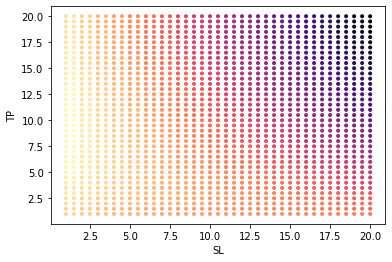

In [12]:
sl_tp('buy', sl=20, tp=20)

In [13]:
#Lighter color mean better results
#From this plot, low SL and medium TP are best

In [14]:
#Top 10 highest scores and wining positions
display(df.nlargest(10, 'score'))
display(df.nlargest(10, 'pos'))


,score,SL,TP,pos
55,21644.0,1.5,9.0,798.0
53,21383.0,1.5,8.0,853.0
57,21271.0,1.5,10.0,735.0
51,20592.0,1.5,7.0,912.0
16,20534.0,1.0,9.0,773.0
18,20215.0,1.0,10.0,711.0
14,20204.0,1.0,8.0,823.0
59,20108.0,1.5,11.0,653.0
56,19944.0,1.5,9.5,774.0
54,19799.0,1.5,8.5,822.0


,score,SL,TP,pos
1482,-44861.0,20.0,1.0,2378.0
1443,-42484.0,19.5,1.0,2376.0
1404,-43004.0,19.0,1.0,2372.0
1365,-40694.0,18.5,1.0,2364.0
1326,-41245.0,18.0,1.0,2356.0
1287,-38888.0,17.5,1.0,2348.0
1248,-39374.0,17.0,1.0,2339.0
1209,-36864.0,16.5,1.0,2331.0
1170,-37357.0,16.0,1.0,2323.0
1131,-34864.0,15.5,1.0,2313.0


In [15]:
#798 / 2944 = 27.07% profit chance
#Top 10 highest scores
#Earned 21644 score with 1.5 SL and 9 TP

#Top 10 highest pos
#More positions mean worse score

In [16]:
#Top 10 lowest scores
#Earned -219760 score with 20 SL and 20 TP

df.nsmallest(10, 'score')

,score,SL,TP,pos
1520,-219680.0,20.0,20.0,273.0
1519,-218264.0,20.0,19.5,282.0
1518,-214988.0,20.0,19.0,295.0
1517,-213374.0,20.0,18.5,305.0
1516,-209498.0,20.0,18.0,325.0
1515,-207885.0,20.0,17.5,340.0
1442,-207577.0,19.0,20.0,273.0
1481,-207538.0,19.5,20.0,273.0
1441,-206226.0,19.0,19.5,282.0
1480,-206188.0,19.5,19.5,282.0


loading...


,score,SL,TP,pos
0,-18.0,3.0,3.0,1465.0
1,-1788.0,3.0,3.5,1374.0
2,2822.0,3.0,4.0,1314.0
3,939.0,3.0,4.5,1256.0
4,4784.0,3.0,5.0,1183.0
...,...,...,...,...
1220,-209498.0,20.0,18.0,325.0
1221,-213374.0,20.0,18.5,305.0
1222,-214988.0,20.0,19.0,295.0
1223,-218264.0,20.0,19.5,282.0


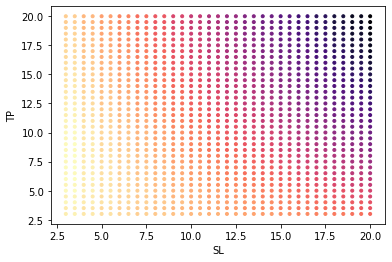

In [17]:
sl_tp('buy', spread=3) #Trading with high spreads

In [18]:
#Highest scores with high spreads
df.nlargest(10, 'score')

,score,SL,TP,pos
43,7222.0,3.5,7.0,1027.0
45,7119.0,3.5,8.0,964.0
41,7017.0,3.5,6.0,1116.0
47,6432.0,3.5,9.0,897.0
39,6072.0,3.5,5.0,1220.0
8,5972.0,3.0,7.0,999.0
10,5920.0,3.0,8.0,937.0
6,5667.0,3.0,6.0,1082.0
12,5340.0,3.0,9.0,872.0
49,5314.0,3.5,10.0,828.0


loading...


,score,SL,TP,pos
0,-148.0,1.0,1.0,1537.0
1,-534.0,1.0,1.5,1484.0
2,4570.0,1.0,2.0,1436.0
3,3865.0,1.0,2.5,1373.0
4,8222.0,1.0,3.0,1314.0
...,...,...,...,...
1516,-187516.0,20.0,18.0,330.0
1517,-189872.0,20.0,18.5,313.0
1518,-191443.0,20.0,19.0,290.0
1519,-194056.0,20.0,19.5,274.0


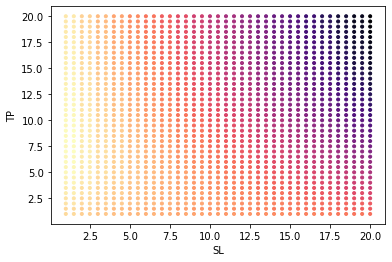

In [19]:
#sell positions
sl_tp('sell', sl=20, tp=20, spread=1)
#770 / 1521 = 50.6% profit chance

In [20]:
#Top 10 highest scores and wining positions with high spreads
display(df.nlargest(10, 'score'))
display(df.nlargest(10, 'pos'))

,score,SL,TP,pos
53,16153.0,1.5,8.0,770.0
55,15912.0,1.5,9.0,672.0
51,15786.0,1.5,7.0,850.0
14,15316.0,1.0,8.0,746.0
57,15197.0,1.5,10.0,581.0
16,15152.0,1.0,9.0,653.0
49,15046.0,1.5,6.0,966.0
12,14938.0,1.0,7.0,822.0
54,14605.0,1.5,8.5,711.0
18,14405.0,1.0,10.0,563.0


,score,SL,TP,pos
1482,-47281.0,20.0,1.0,2337.0
1443,-44782.0,19.5,1.0,2333.0
1404,-45242.0,19.0,1.0,2324.0
1365,-42916.0,18.5,1.0,2313.0
1326,-43372.0,18.0,1.0,2306.0
1287,-40930.0,17.5,1.0,2300.0
1248,-41416.0,17.0,1.0,2297.0
1209,-38827.0,16.5,1.0,2289.0
1170,-39269.0,16.0,1.0,2286.0
1131,-36802.0,15.5,1.0,2273.0


In [21]:
df.nsmallest(10, 'score')

,score,SL,TP,pos
1520,-194680.0,20.0,20.0,262.0
1519,-194056.0,20.0,19.5,274.0
1518,-191443.0,20.0,19.0,290.0
1517,-189872.0,20.0,18.5,313.0
1516,-187516.0,20.0,18.0,330.0
1515,-186634.0,20.0,17.5,343.0
1514,-184266.0,20.0,17.0,362.0
1442,-183854.0,19.0,20.0,262.0
1481,-183854.0,19.5,20.0,262.0
1441,-183274.0,19.0,19.5,274.0


In [22]:
#^^^If high spreads exist, we make less money
#sad

#If we want to maximize profits,
#scalping might be the worst approach.
#1.5 SL and 9 TP , and total buy 798 positions are executed within 10 years

In [5]:
#Train buy
buy_df_copy['Result'] = np.where(((buy_df_copy['close'] - buy_df_copy['next_min'] < round(1.5, 2)) &
                                (buy_df_copy['next_max'] - buy_df_copy['close'] > round(9, 2))) |
                                ((buy_df_copy['next_max'] - buy_df_copy['close'] > round(9, 2)) &
                                (buy_df_copy['next_max_time'] > buy_df_copy['next_min_time'])),
                                1, 0)

buy_df_closeMA_copy = buy_df_copy[(buy_df_copy['close_to_MA'] == True)]
buy_df_good_copy = buy_df_copy[(buy_df_copy['close_to_MA'] == True) & (buy_df_copy['Result'] == 1)]
buy_df_bad_copy = buy_df_copy[(buy_df_copy['close_to_MA'] == True) & (buy_df_copy['Result'] == 0)]
buy_df_train = buy_df_copy

#Evaluate buy
buy_df_test['Result'] = np.where(((buy_df_test['close'] - buy_df_test['next_min'] < round(1.5, 2)) &
                                (buy_df_test['next_max'] - buy_df_test['close'] > round(9, 2))) |
                                ((buy_df_test['next_max'] - buy_df_test['close'] > round(9, 2)) &
                                (buy_df_test['next_max_time'] > buy_df_test['next_min_time'])),
                                1, 0)

buy_df_closeMA_test = buy_df_test[(buy_df_test['close_to_MA'] == True)]
buy_df_good_test = buy_df_test[(buy_df_test['close_to_MA'] == True) & (buy_df_test['Result'] == 1)]
buy_df_bad_test = buy_df_test[(buy_df_test['close_to_MA'] == True) & (buy_df_test['Result'] == 0)]

#Train sell
sell_df_copy['Result'] = np.where(((sell_df_copy['close'] - sell_df_copy['next_max'] > round(-1.5, 2)) &
                                (sell_df_copy['next_min'] - sell_df_copy['close'] < round(-8, 2))) |
                                ((sell_df_copy['next_min'] - sell_df_copy['close'] < round(-8, 2)) &
                                (sell_df_copy['next_max_time'] < sell_df_copy['next_min_time'])),
                                1, 0)

sell_df_closeMA_copy = sell_df_copy[(sell_df_copy['close_to_MA'] == True)]
sell_df_good_copy = sell_df_copy[(sell_df_copy['close_to_MA'] == True) & (sell_df_copy['Result'] == 1)]
sell_df_bad_copy = sell_df_copy[(sell_df_copy['close_to_MA'] == True) & (sell_df_copy['Result'] == 0)]
sell_df_train = sell_df_copy

display(sell_df_train)
#Evaluate sell
sell_df_test['Result'] = np.where(((sell_df_test['close'] - sell_df_test['next_max'] > round(-1.5, 2)) &
                                (sell_df_test['next_min'] - sell_df_test['close'] < round(-8, 2))) |
                                ((sell_df_test['next_min'] - sell_df_test['close'] < round(-8, 2)) &
                                (sell_df_test['next_max_time'] < sell_df_test['next_min_time'])),
                                1, 0)

sell_df_closeMA_test = sell_df_test[(sell_df_test['close_to_MA'] == True)]
sell_df_good_test = sell_df_test[(sell_df_test['close_to_MA'] == True) & (sell_df_test['Result'] == 1)]
sell_df_bad_test = sell_df_test[(sell_df_test['close_to_MA'] == True) & (sell_df_test['Result'] == 0)]                                  



,index,close,low,time,MA_hour,MA_day,MA_week,average-MA_distance,close_to_MA,next_min,next_max,next_min_nodup,next_max_nodup,next_min_time,next_max_time,position_type,Result
0,0,1098.03,1095.85,2009-12-31 16:00:00,NaN,NaN,NaN,NaN,False,1094.49,1122.30,1094.49,1122.3,2009-12-31 16:00:00,2009-12-31 16:00:00,sell_position,0
1,1,1096.40,1094.20,2009-12-31 17:00:00,NaN,NaN,NaN,NaN,False,1094.49,1122.30,NaN,NaN,2010-01-04 01:00:00,2010-01-04 03:00:00,sell_position,0
2,2,1098.30,1095.35,2009-12-31 18:00:00,NaN,NaN,NaN,NaN,False,1094.49,1122.30,NaN,NaN,2010-01-04 01:00:00,2010-01-04 03:00:00,sell_position,0
3,3,1094.49,1093.08,2010-01-04 01:00:00,NaN,NaN,NaN,NaN,False,1095.65,1122.30,1095.65,NaN,2010-01-04 01:00:00,2010-01-04 03:00:00,sell_position,0
4,4,1095.65,1094.00,2010-01-04 02:00:00,NaN,NaN,NaN,NaN,False,1097.87,1122.30,1097.87,NaN,2010-01-04 02:00:00,2010-01-04 03:00:00,sell_position,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11913,54700,1273.07,1272.83,2019-05-23 07:00:00,1274.24,1290.76,1276.45,0.12,False,1273.93,1286.21,NaN,NaN,2019-05-23 09:00:00,2019-05-23 18:00:00,sell_position,0
11914,54702,1273.93,1273.77,2019-05-23 09:00:00,1274.15,1290.73,1276.46,0.03,False,1274.50,1286.21,1274.50,NaN,2019-05-23 09:00:00,2019-05-23 18:00:00,sell_position,0
11915,54814,1276.28,1274.95,2019-05-30 10:00:00,1280.79,1289.13,1276.77,0.28,False,1276.52,1295.11,1276.52,NaN,2019-05-30 10:00:00,2019-05-30 16:00:00,sell_position,0
11916,54816,1276.52,1276.03,2019-05-30 12:00:00,1280.55,1289.09,1276.78,0.12,False,1276.72,1298.78,1276.72,NaN,2019-05-30 12:00:00,2019-05-30 16:00:00,sell_position,0


In [ ]:
visualize_(buy_df_closeMA_copy)

In [ ]:
visualize_(buy_df_good_copy)

In [ ]:
visualize_(buy_df_closeMA_copy, sell_df_closeMA_copy)
#1567 / 5829 = 26.87% profit chance

In [6]:
#Cluster positions by date to increase profit chance

def cluster_date(df):
    df['valid'] = np.nan
    valid_arr = np.array([])
    for num in range(len(df)):
        valid = np.array([])
        for num2 in range(1, 20):
            
            if (abs(df['time'].iloc[num] - df['time'].iloc[num - num2]) < timedelta(days=1)
               ) and (df['Result'].iloc[num - num2] == 0):
                valid = np.append(valid, False)
            else:
                valid = np.append(valid, True)
        
        valid_arr = np.append(valid_arr, all(valid))
    df['valid'] = valid_arr

cluster_date(buy_df_closeMA_copy)
cluster_date(buy_df_closeMA_test)
cluster_date(sell_df_closeMA_copy)
cluster_date(sell_df_closeMA_test)




In [7]:
buy_df_closeMA_valid_good = buy_df_closeMA_copy[(buy_df_closeMA_copy['Result'] == 1) & (buy_df_closeMA_copy['valid'] == 1)]
buy_df_train_valid = buy_df_closeMA_copy[buy_df_closeMA_copy['valid'] == 1]
buy_df_test_valid = buy_df_closeMA_test[buy_df_closeMA_test['valid'] == 1]

sell_df_closeMA_valid_good = sell_df_closeMA_copy[(sell_df_closeMA_copy['Result'] == 1) & (sell_df_closeMA_copy['valid'] == 1)]
sell_df_train_valid = sell_df_closeMA_copy[sell_df_closeMA_copy['valid'] == 1]
sell_df_test_valid = sell_df_closeMA_test[sell_df_closeMA_test['valid'] == 1]

display(buy_df_test_valid)
#753 positions in 2944 positions are valid


# 396 / 755 = 52.5% valid positions are good
#By clustering positions, our profit chance increased from 26.87% to 52.5%

,index,close,low,time,MA_hour,MA_day,MA_week,average-MA_distance,close_to_MA,next_min,next_max,next_min_nodup,next_max_nodup,next_min_time,next_max_time,position_type,Result,valid
13518,58328,1564.16,NaN,2020-01-06 17:00:00,1550.84,1481.83,1341.61,15.55,True,1557.79,1571.07,NaN,1571.07,2020-01-07 03:00:00,2020-01-06 17:00:00,buy_position,0,1.0
13559,58370,1577.18,NaN,2020-01-08 13:00:00,1573.39,1484.79,1343.37,6.34,True,1544.14,1576.73,NaN,1576.73,2020-01-09 08:00:00,2020-01-08 13:00:00,buy_position,0,1.0
13579,58435,1552.69,NaN,2020-01-13 09:00:00,1552.35,1488.21,1346.00,2.62,True,1537.61,1554.92,NaN,NaN,2020-01-14 03:00:00,2020-01-13 14:00:00,buy_position,0,1.0
13583,58473,1549.51,NaN,2020-01-15 01:00:00,1548.71,1489.53,1347.51,5.51,True,1547.31,1556.96,NaN,1556.96,2020-01-15 03:00:00,2020-01-15 01:00:00,buy_position,0,1.0
13670,58569,1559.40,NaN,2020-01-21 09:00:00,1559.03,1494.11,1351.46,2.78,True,1550.91,1558.67,NaN,1558.67,2020-01-22 07:00:00,2020-01-21 09:00:00,buy_position,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16860,69290,1853.10,NaN,2021-11-12 11:00:00,1851.78,1783.91,1830.82,8.43,True,1846.15,1867.87,NaN,NaN,2021-11-12 12:00:00,2021-11-12 20:00:00,buy_position,1,1.0
16861,69293,1853.49,NaN,2021-11-12 14:00:00,1853.23,1784.00,1830.86,5.39,True,1854.45,1867.87,1854.45,NaN,2021-11-12 14:00:00,2021-11-12 20:00:00,buy_position,1,1.0
16862,69294,1854.45,NaN,2021-11-12 15:00:00,1853.81,1784.03,1830.87,4.38,True,1856.93,1867.87,1856.93,NaN,2021-11-12 15:00:00,2021-11-12 20:00:00,buy_position,1,1.0
16876,69309,1858.95,NaN,2021-11-15 07:00:00,1858.83,1784.64,1831.10,0.17,True,1857.39,1867.46,NaN,NaN,2021-11-15 08:00:00,2021-11-15 09:00:00,buy_position,0,1.0


In [ ]:
visualize_(buy_df_train_valid)

5085     31.42
5092     18.55
5125     15.97
1220     15.65
4957     13.38
5160     13.33
1756     12.43
5140     10.43
5421     10.39
10825    10.20
4822      9.83
12784     9.29
3919      9.20
4782      9.12
5300      8.93
3373      8.89
4986      8.53
13226     8.22
2547      8.05
4783      8.00
Name: close-low, dtype: float64

Text(0.5, 0, 'Points')

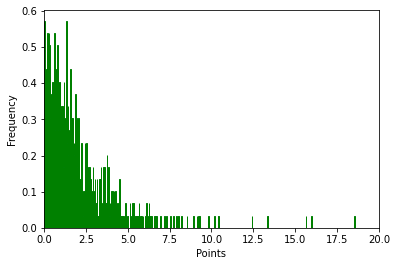

In [7]:
#calculate distance between close and low
buy_df_train_valid['close-low'] = buy_df_train_valid['close'] - buy_df_train_valid['low']

display(buy_df_train_valid['close-low'].nlargest(20))

#Plot histogram of low of all valid close-MA candlesticks
buy_df_train_valid['close-low'].plot(kind='hist', density=True, edgecolor='green', bins=800)
plt.xlim(0, 20)
plt.xlabel('Points')

In [ ]:
#4 / 753 = 0.005% the price low may accidentally hit stop loss(if exceed 1.5 points)

In [8]:
#DataFrame of all possible buy positions

all_pos = pd.DataFrame(df_close.loc[:, ['close', 'time']])

train_pos = all_pos[all_pos['time'] < '2019-12-31']
test_pos = all_pos[all_pos['time'] > '2019-12-31']

global bpos
global spos
global bpos_test
global spos_test
bpos = buy_df_train_valid.loc[:,['close', 'time', 'Result']]
bpos = pd.concat([train_pos, bpos], axis=0)
bpos = bpos.drop_duplicates('time', keep='last').reset_index(drop=True)
bpos = bpos.sort_values('time')

bpos_test = buy_df_test_valid.loc[:,['close', 'time', 'Result']]
bpos_test = pd.concat([bpos_test, test_pos], axis=0)
bpos_test = bpos_test.drop_duplicates('time', keep='first').reset_index(drop=True)
bpos_test = bpos_test.sort_values('time')

spos = sell_df_train_valid.loc[:,['close', 'time', 'Result']]
spos = pd.concat([train_pos, spos], axis=0)
spos = spos.drop_duplicates('time', keep='last').reset_index(drop=True)
spos = spos.sort_values('time')

spos_test = sell_df_test_valid.loc[:,['close', 'time', 'Result']]
spos_test = pd.concat([test_pos, spos_test], axis=0)
spos_test = spos_test.drop_duplicates('time', keep='last').reset_index(drop=True)
spos_test = spos_test.sort_values('time')





In [9]:

#DataFrame for training models
#Period can be 1, 3, 7 days etc
def df_setup(pos_type, period_day, train_test='train'):
    
    if pos_type == 'blue' or pos_type == 'buy':
        col = 'Blue_cs'
        no_pos_type = 'red'
        if train_test == 'train':
            position = bpos['close']
            pos = bpos
        elif train_test == 'test':
            position = bpos_test['close']
            pos = bpos_test
    elif pos_type == 'red' or pos_type == 'sell':
        col = 'Red_cs'
        no_pos_type = 'blue'
        if train_test == 'train':
            position = spos['close']
            pos = spos
        elif train_test == 'test':
            position = spos_test['close']
            pos = spos_test
        #pos = spos
    else:
        print('Invalid values')
    
    #Convert day(s) to hours
    period = period_day * 24
    
    #Compare each row with previous row to determine candlestick type
    pos['Candlestick'] = pos.close.ge(pos.close.shift())
    pos['Candlestick'] = pos['Candlestick'].replace(True, 'blue')
    pos['Candlestick'] = pos['Candlestick'].replace(False, 'red')
    
    #Position, Mean, Min, Max, STD, amount of Candlestick_type within period of time
    data = {'close':position,
            'Mean':pos.close.rolling(period).mean().shift(),
            'Min':pos.close.rolling(period).min().shift(),
           'Max':pos.close.rolling(period).max().shift(),
           'Std':pos.close.rolling(period).std().shift(),
           '{}'.format(col):pos.Candlestick.replace(
               '{}'.format(no_pos_type), np.NaN).
            rolling(period, min_periods=0).count(),
           'Result':pos['Result']}
    
    df = pd.DataFrame(data)
    
    df['Min'] = df.close / df.Min
    df['Max'] = df.close / df.Max
    df['Mean'] = df.close / df.Mean
    
    df['{}'.format(col)] = df['{}'.format(col)].astype('int32')
    df = df[(df['close'].astype('str') != 'nan')]
    df = df.dropna()
    return df

#Dataframe of 3 days stat of buy positions
df_setup('buy', 3)


,close,Mean,Min,Max,Std,Blue_cs,Result
57514,1132.00,1.007270,1.026432,0.993200,8.159535,38,0.0
57515,1151.66,1.012182,1.027030,0.992528,11.481065,38,0.0
57516,1143.23,0.999562,1.015564,0.985263,11.086012,42,0.0
57517,1136.20,1.000212,1.009319,0.992722,4.606671,35,0.0
57518,1135.62,1.000332,1.005873,0.993404,3.591117,32,0.0
...,...,...,...,...,...,...,...
58261,1510.17,1.004137,1.015097,0.997536,8.934558,36,0.0
58262,1508.49,1.009596,1.020968,0.996716,11.839909,44,0.0
58263,1511.98,1.004584,1.018203,0.997928,9.375832,39,1.0
58264,1512.44,1.004405,1.016766,0.998231,8.796300,39,1.0


In [425]:
#Training dataset
display(df_setup('buy', 3, 'train'))
#Evaluating dataset
display(df_setup('buy', 3, 'test'))

print(df_setup('buy', 3, 'train')['Result'].value_counts())

,close,Mean,Min,Max,Std,Blue_cs,Result
57514,1132.00,1.007270,1.026432,0.993200,8.159535,38,0.0
57515,1151.66,1.012182,1.027030,0.992528,11.481065,38,0.0
57516,1143.23,0.999562,1.015564,0.985263,11.086012,42,0.0
57517,1136.20,1.000212,1.009319,0.992722,4.606671,35,0.0
57518,1135.62,1.000332,1.005873,0.993404,3.591117,32,0.0
...,...,...,...,...,...,...,...
58261,1510.17,1.004137,1.015097,0.997536,8.934558,36,0.0
58262,1508.49,1.009596,1.020968,0.996716,11.839909,44,0.0
58263,1511.98,1.004584,1.018203,0.997928,9.375832,39,1.0
58264,1512.44,1.004405,1.016766,0.998231,8.796300,39,1.0


,close,Mean,Min,Max,Std,Blue_cs,Result
1,1577.18,1.005513,1.021331,0.986360,13.715746,42,0.0
2,1552.69,0.996410,1.005537,0.973803,12.218351,34,0.0
3,1549.51,0.999955,1.007739,0.992156,5.905686,36,0.0
4,1559.40,1.001311,1.006123,0.995163,4.099284,38,0.0
5,1558.89,1.000462,1.005145,0.994837,3.544195,39,0.0
...,...,...,...,...,...,...,...
192,1853.10,1.004976,1.018086,0.994222,15.339252,31,1.0
193,1853.49,1.004582,1.016246,0.994431,14.719893,31,1.0
194,1854.45,1.004891,1.016772,0.994946,14.564341,32,1.0
195,1858.95,1.003528,1.019038,0.995225,12.664496,35,0.0


1.0    394
0.0    358
Name: Result, dtype: int64


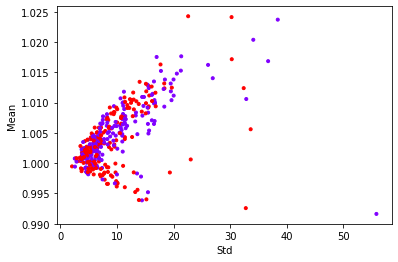

Text(0, 0.5, 'Mean')

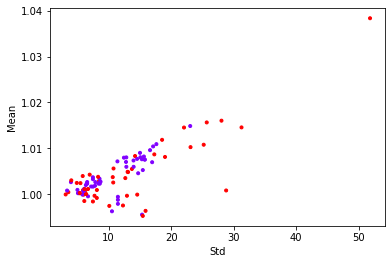

In [435]:
%matplotlib inline
#Visualize data with decreased data granularity

train_data = df_setup('buy', 3, 'train')[::2]
test_data = df_setup('buy', 3, 'test')[::2]
train_data = train_data.replace(['Good', 'Bad'], [1, 0])
test_data = test_data.replace(['Good', 'Bad'], [1, 0])

plt.scatter(train_data['Std'], train_data['Mean'], marker='.', c=train_data['Result'], cmap='rainbow_r')
plt.xlabel('Std')
plt.ylabel('Mean')
plt.show()

plt.scatter(test_data['Std'], test_data['Mean'], marker='.', c=test_data['Result'], cmap='rainbow_r')
plt.xlabel('Std')
plt.ylabel('Mean')

#Relationship between std and mean of every possible position(train data)
#Relationship between std and mean of every possible position(test data)

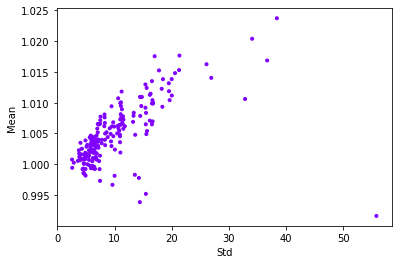

Text(0, 0.5, 'Mean')

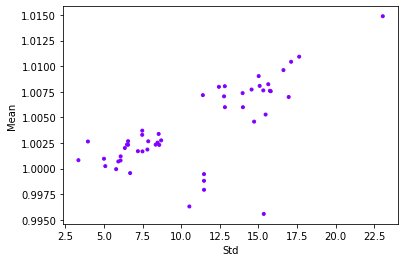

In [437]:
train_data_good = train_data[train_data['Result'] == 1]
test_data_good = test_data[test_data['Result'] == 1]

plt.scatter(train_data_good['Std'], train_data_good['Mean'], marker='.', c=train_data_good['Result'], cmap='rainbow')
plt.xlabel('Std')
plt.ylabel('Mean')
plt.show()

plt.scatter(test_data_good['Std'], test_data_good['Mean'], marker='.', c=test_data_good['Result'], cmap='rainbow')
plt.xlabel('Std')
plt.ylabel('Mean')
#Relationship between std and mean of every winning position(train data)
#Relationship between std and mean of every winning position(test data)

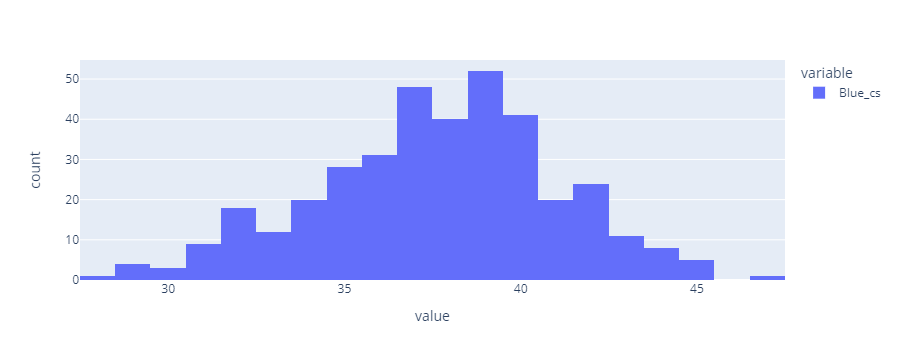

In [428]:
train_data.Blue_cs.plot(kind='hist')
#Amount of blue candlesticks(prices go up) occur before every possible position

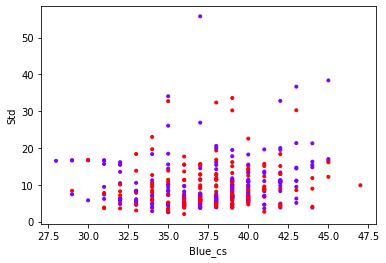

Text(0, 0.5, 'Std')

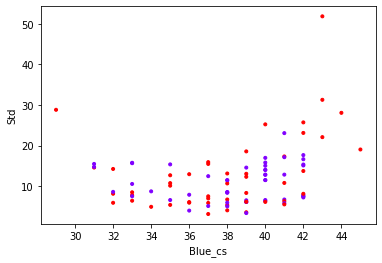

In [438]:
train_data = df_setup('buy', 3, 'train')[::2]
test_data = df_setup('buy', 3, 'test')[::2]
train_data = train_data.replace(['Good', 'Bad'], [1, 0])
test_data = test_data.replace(['Good', 'Bad'], [1, 0])
plt.scatter(train_data['Blue_cs'], train_data['Std'], marker='.', c=train_data['Result'], cmap='rainbow_r')
plt.xlabel('Blue_cs')
plt.ylabel('Std')
plt.show()

plt.scatter(test_data['Blue_cs'], test_data['Std'], marker='.', c=test_data['Result'], cmap='rainbow_r')
plt.xlabel('Blue_cs')
plt.ylabel('Std')

#Relationship between blue candlesticks and std of every possible position(train data)
#Relationship between blue candlesticks and std of every possible position(test data)

In [61]:
#Conclusion: Data is highly uncorrelated 

In [194]:
#I try to train it to see the result

In [440]:
# Training parameters.

learning_rate = 0.0001

batch_size = 10
num = 3

#Mean, Std, Blue_cs columns for training and testing data
    
#df_train = df_setup('buy', num).drop('Result', axis=1)
df_train = df_setup('buy', num).drop('Result', axis=1).drop('Max', axis=1).drop('Min', axis=1).drop('close', axis=1)
df_train_re = df_setup('buy', num)['Result']

#df_test = df_setup('buy', num, 'test').drop('Result', axis=1)
df_test = df_setup('buy', num, 'test').drop('Result', axis=1).drop('Max', axis=1).drop('Min', axis=1).drop('close', axis=1)
df_test_re = df_setup('buy', num, 'test')['Result']

    
x_train, y_train = np.array(df_train, np.float64), np.array(df_train_re, np.int16)
x_test, y_test = np.array(df_test, np.float64), np.array(df_test_re, np.int16)
    
x_train = np.round_(x_train, decimals=6)
x_test = np.round_(x_test, decimals=6)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().batch(batch_size)



In [ ]:
#Tensorflow Logistic Regression

Epoch 1/20
1000/1000 [==============================] - 4s 2ms/step - loss: 1.8294 - tp: 1740.0000 - fp: 1292.0000 - tn: 3482.0000 - fn: 3486.0000 - accuracy: 0.5222 - precision: 0.5739 - recall: 0.3330 - auc: 0.5354
Epoch 2/20
1000/1000 [==============================] - 2s 2ms/step - loss: 1.5168 - tp: 2487.0000 - fp: 2010.0000 - tn: 2730.0000 - fn: 2773.0000 - accuracy: 0.5217 - precision: 0.5530 - recall: 0.4728 - auc: 0.5423
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/step - loss: 1.4086 - tp: 2548.0000 - fp: 2221.0000 - tn: 2553.0000 - fn: 2678.0000 - accuracy: 0.5101 - precision: 0.5343 - recall: 0.4876 - auc: 0.5389
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2892 - tp: 2604.0000 - fp: 2317.0000 - tn: 2443.0000 - fn: 2636.0000 - accuracy: 0.5047 - precision: 0.5292 - recall: 0.4969 - auc: 0.5435
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2235 - tp: 2661.0000 - fp: 2353.0000 - tn: 2403.0000 -

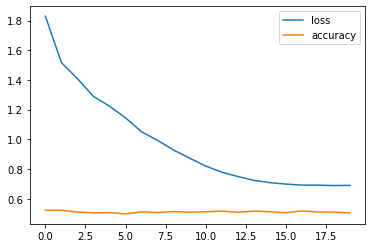

In [442]:

model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(1, activation='sigmoid')])

METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')]
    
opt = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer=opt,
loss='binary_crossentropy',
metrics=METRICS)
train_history = model.fit(train_data, epochs=20, steps_per_epoch=1000)

loss = train_history.history['loss']
acc = train_history.history['accuracy']
    
plt.plot(loss)
plt.plot(acc)
plt.legend(['loss', 'accuracy'])
plt.show()



In [443]:
model.evaluate(x_test, y_test, verbose=1)

7/7 [==============================] - 2s 2ms/step - loss: 0.7073 - tp: 74.0000 - fp: 71.0000 - tn: 26.0000 - fn: 25.0000 - accuracy: 0.5102 - precision: 0.5103 - recall: 0.7475 - auc: 0.5034


[0.7073250412940979,
 74.0,
 71.0,
 26.0,
 25.0,
 0.5102040767669678,
 0.5103448033332825,
 0.747474730014801,
 0.5034364461898804]

In [62]:
#Testing
#accuracy 51.02%, precision 51.03%, recall 74.75%, auc 50.34%

In [444]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
clf.score(x_train, y_train)
clf.score(x_test, y_test)

#Sklearn LogisticRegression accuracy

0.4846938775510204

In [11]:
#Most data are too uncorrelated to make a good regression model

#This time I try time series forecasting with LSTM

In [37]:
#Train
#Predict
train = train_pos['close']
test = test_pos['close']

#Use 12 inputs to predict 6 outputs
inputs = 12
outputs = 6

train_x = np.zeros([len(train), 12])
test_x = np.zeros([len(test), 12])
zero = np.zeros([1])

train = pd.concat([train, pd.DataFrame(zero)], axis=0)
test = pd.concat([test, pd.DataFrame(zero)], axis=0)
train = train.squeeze()
test = test.squeeze()

for num in range(len(train)):
    try:
        train_x[-num-1] = train.iloc[-num-1 - inputs:-num-1]
    except ValueError:
        train_x[train_x == 0] = np.nan
        train_x = train_x[~np.isnan(train_x).any(axis=1)]
        break
            
for num2 in range(len(test_x)):
    try:
        test_x[-num2-1] = test.iloc[-num2-1 - inputs:-num2-1]
    except ValueError:
        test_x[test_x == 0] = np.nan
        test_x = test_x[~np.isnan(test_x).any(axis=1)]
        break
 
    
train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)
train = pd.DataFrame(train)
test = pd.DataFrame(test)


train_y = train_x.shift(periods=-1).iloc[0:len(train_x), -1]
test_y = test_x.shift(periods=-1).iloc[0:len(test_x), -1]
    
train_y = train_y.values.reshape(-1, 1)
test_y = test_y.values.reshape(-1, 1)
train = train.values.reshape(-1, 1)
test = test.values.reshape(-1, 1)

train_x = np.array(train_x)
test_x = np.array(test_x)
    
#Normalize data
from sklearn.preprocessing import StandardScaler
scalerx = MinMaxScaler(feature_range = (0, 1)).fit(train_x)
scalery = MinMaxScaler(feature_range = (0, 1)).fit(train_y)
scaler = MinMaxScaler(feature_range = (0, 1))

train_x = scalerx.transform(train_x)
test_x = scalerx.transform(test_x)

train_y = scalery.transform(train_y)
test_y = scalery.transform(test_y)

#Remove last row
train_x = train_x[:-1, :]
train_y = train_y[:-1, :]
test = test[:-1, :]
train = train[:-1, :]

train = scaler.fit_transform(train)
test = scaler.transform(test)
    
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))



In [18]:
%%time

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                patience=2,
                                                mode='min')

# Shape [batch, time, features]
model = tf.keras.models.Sequential([
tf.keras.layers.LSTM(outputs, return_sequences=False, recurrent_dropout=0.6),
tf.keras.layers.Dense(units=1)])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.metrics.MeanAbsoluteError()])
train_history = model.fit(train_x, train_y, epochs=15, batch_size=1, callbacks=[early_stopping])

loss = train_history.history['loss']
acc = train_history.history['mean_absolute_error']


Epoch 1/15
58254/58254 [==============================] - 278s 5ms/step - loss: 5.6820e-05 - mean_absolute_error: 0.0051
Epoch 2/15
58254/58254 [==============================] - 279s 5ms/step - loss: 3.2201e-05 - mean_absolute_error: 0.0040
Epoch 3/15
58254/58254 [==============================] - 279s 5ms/step - loss: 2.7058e-05 - mean_absolute_error: 0.0036
Epoch 4/15
58254/58254 [==============================] - 279s 5ms/step - loss: 2.4014e-05 - mean_absolute_error: 0.0034
Epoch 5/15
58254/58254 [==============================] - 308s 5ms/step - loss: 2.1311e-05 - mean_absolute_error: 0.0032
Epoch 6/15
58254/58254 [==============================] - 305s 5ms/step - loss: 2.0020e-05 - mean_absolute_error: 0.0031
Epoch 7/15
58254/58254 [==============================] - 282s 5ms/step - loss: 1.9001e-05 - mean_absolute_error: 0.0030
Epoch 8/15
58254/58254 [==============================] - 314s 5ms/step - loss: 1.7970e-05 - mean_absolute_error: 0.0029
Epoch 9/15
58254/58254 [========

In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 6)                    192       
                                                                 
 dense (Dense)               (1, 1)                    7         
                                                                 
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
None


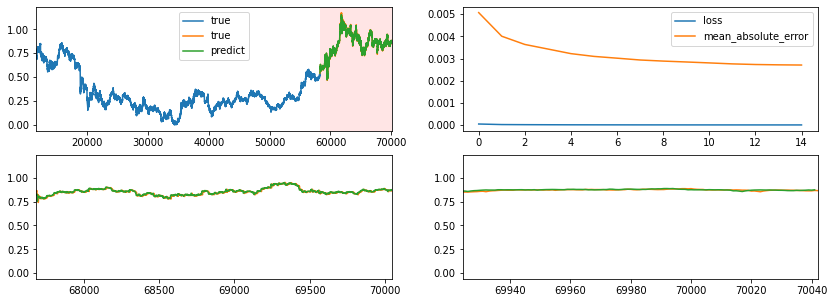

In [20]:
#Prediction and plot

y_pred = model.predict(test_x, batch_size=1)
zeros = np.zeros([outputs - 1, 1])
zeros[zeros == 0] = np.NaN
y_pred = np.insert(y_pred, 0, zeros, axis=0)

time = np.arange(0, len(train))
time_test = np.arange(len(train), len(train) + len(test))
time_test2 = np.arange(len(train), len(train) + len(y_pred))

fig, ax = plt.subplots(2, 2, figsize=(14, 5))
ax[0, 0].plot(time, train)
ax[0, 0].set_xlim(len(train) * 20 / 100, len(train) + len(y_pred))
ax[0, 0].plot(time_test, test)
ax[0, 0].plot(time_test2, y_pred)

ax[0, 0].legend(['true', 'true', 'predict'])
ax[0, 0].axvspan(len(train), len(train) + len(test), facecolor='red', alpha=0.1)
    
ax[0, 1].plot(loss)
ax[0, 1].plot(acc)
ax[0, 1].legend(['loss', 'mean_absolute_error'])
    
ax[1, 0].plot(time, train)
ax[1, 0].set_xlim(len(train) + (len(y_pred) * 80 / 100), len(train) + len(y_pred))
ax[1, 0].plot(time_test, test)
ax[1, 0].plot(time_test2, y_pred)
    
ax[1, 1].plot(time, train)
ax[1, 1].set_xlim(len(train) + (len(y_pred) * 99 / 100), len(train) + len(y_pred))
ax[1, 1].plot(time_test, test)
ax[1, 1].plot(time_test2, y_pred)

#Blue line: train data
#Orange line: test data
#Green line: model prediction

#Good prediction

In [ ]:
#Plotly plot

time_ = np.arange(0, len(test))
time2_ = np.arange(outputs, len(y_pred))
df_plot = pd.concat([pd.DataFrame(time_), pd.DataFrame(time2_), pd.DataFrame(test), pd.DataFrame(test_y) ,pd.DataFrame(y_pred)], axis=1)

df_plot.columns = ['time', 'time2', 'test_x', 'test_y' ,'prediction']
#Predict vs actual results
fig = go.Figure()
trace = go.Scatter(x=df_plot['time'], y=df_plot['test_x'], mode='lines', name='True', hoverinfo='skip')
trace2 = go.Scatter(x=df_plot['time2'], y=df_plot['prediction'], mode='lines', name='Predict', hoverinfo='skip')
fig.add_trace(trace)
fig.add_trace(trace2)
fig.show()



In [43]:
#Save trained model
model.save(r'C:\Python\tensorflow_models\algotrading model')

#This warning is a bug yet to be fixed
#https://github.com/keras-team/keras/issues/15964#issuecomment-1033008149

INFO:tensorflow:Assets written to: C:\Python\tensorflow_models\algotrading model\assets


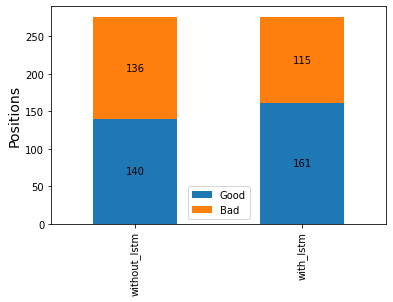

In [123]:
#LSTM calculation
zeros = np.zeros([outputs, 1])
y_pred_new = np.insert(y_pred, 0, zeros, axis=0)

#Process LSTM prediction data for buy
bpos_test_plot = bpos_test.copy()
bpos_test_plot['close'] = test
bpos_test_plot['pred'] = y_pred_new
bpos_test_plot['pred'] = bpos_test_plot['pred'].shift(outputs)
bpos_test_plot = bpos_test_plot.reset_index()
bpos_test_reversed_plot = bpos_test_plot['pred'].iloc[::-1]
bpos_test_plot['pred_mean'] = bpos_test_reversed_plot.rolling(outputs, min_periods=1).mean()
bpos_test_plot['pred_type'] = np.where((bpos_test_plot['pred_mean'] > bpos_test_plot['close']), 1, 0)

#Process LSTM prediction data for sell
spos_test_plot = spos_test.copy()
spos_test_plot['close'] = test
spos_test_plot['pred'] = y_pred_new
spos_test_plot['pred'] = spos_test_plot['pred'].shift(outputs)
spos_test_plot = spos_test_plot.reset_index()
spos_test_reversed_plot = spos_test_plot['pred'].iloc[::-1]
spos_test_plot['pred_mean'] = spos_test_reversed_plot.rolling(outputs, min_periods=1).mean()
spos_test_plot['pred_type'] = np.where((spos_test_plot['pred_mean'] < spos_test_plot['close']), 1, 0)

#Filter data
df_plot_buy = bpos_test_plot.loc[:, ['Result', 'pred_type']]
df_plot_sell = spos_test_plot.loc[:, ['Result', 'pred_type']]

df_plot_buy_re_good = df_plot_buy[(df_plot_buy['Result'] == 1)]
df_plot_buy_re_bad = df_plot_buy[(df_plot_buy['Result'] == 0)]
df_plot_buy_re_pred_good = df_plot_buy[((df_plot_buy['Result'] == 0) | (df_plot_buy['Result'] == 1)) & (df_plot_buy['pred_type'] == 1)]
df_plot_buy_re_pred_bad = df_plot_buy[((df_plot_buy['Result'] == 0) | (df_plot_buy['Result'] == 1)) & (df_plot_buy['pred_type'] == 0)]

df_plot_sell_re_good = df_plot_sell[(df_plot_sell['Result'] == 1)]
df_plot_sell_re_bad = df_plot_sell[(df_plot_sell['Result'] == 0)]
df_plot_sell_re_pred_good = df_plot_sell[((df_plot_sell['Result'] == 0) | (df_plot_sell['Result'] == 1)) & (df_plot_sell['pred_type'] == 1)]
df_plot_sell_re_pred_bad = df_plot_sell[((df_plot_sell['Result'] == 0) | (df_plot_sell['Result'] == 1)) & (df_plot_sell['pred_type'] == 0)]

#Bar chart from dataframe
df_plot_lstm = pd.DataFrame({'without_lstm':[len(df_plot_buy_re_good) + len(df_plot_sell_re_good),
                                             len(df_plot_buy_re_bad) + len(df_plot_sell_re_bad)],
                            'with_lstm':[len(df_plot_buy_re_pred_good) + len(df_plot_sell_re_pred_good),
                                     len(df_plot_buy_re_pred_bad) + len(df_plot_sell_re_pred_bad)]})
                                   
df_plot_lstm = df_plot_lstm.transpose()
plot_lstm = df_plot_lstm.plot.bar(stacked=True)
plt.ylabel("Positions", size=14)
plt.legend(['Good', 'Bad'])

for bar in plot_lstm.patches:
    width, height = bar.get_width(), bar.get_height()
    x, y = bar.get_xy() 
    plot_lstm.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
    
#Chance of winning a trade improved from 50.7% to 58.33%
